In [1]:
# !pip install wheel
# !pip install h5py
# !pip install torch==1.10.0+cu113 torchvision==0.11.1+cu113 torchaudio==0.10.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [2]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import h5py
import yaml
import pickle
import os
import argparse
import random
from tqdm.notebook import tqdm
from collections import Counter
from dataclasses import dataclass, field
import contextlib
import math

In [3]:
data = pd.read_csv('../processed_data/utrs.csv')
data = data[['Gene Name', 'foreign']].dropna(axis=0).rename(columns={'Gene Name': 'gene', 'foreign':'seq'})

In [4]:
data.head()

,gene,seq
4,VPS8,ACATTTCTAAATATTTAATACAACTTTGGTTACATAAAAGTAAAAT...
5,SSA1,AGCCAATTGGTGCGGCAATTGATAATAACGAAAATGTCTTTTAATG...
6,ERP2,AGAACTTTTCAATCTACGAAAAATATATGTCCGCAATATAGAACAC...
7,FUN14,AGCAAGACAAATGACCAGATATAAACGAGGGTTATATTCTTTCGTT...
8,SPO7,AAAGAGTTGGAGGGCTTCTTCCTTCGAATAAGAGGTCATATTTACC...


In [91]:
from itertools import product

In [92]:

def entropy(string):
    "Calculates the Shannon entropy of a string"

    # get probability of chars in string
    prob = [ float(string.count(c)) / len(string) for c in dict.fromkeys(list(string)) ]

    # calculate the entropy
    entropy = - sum([ p * math.log(p) / math.log(2.0) for p in prob ])

    return min(1, abs(entropy) / 2)

In [93]:
# Efficiency element
eff_el1 = "TATATA"
eff_el2 = "TTTTTATA"
eff_ctrl = "GCGCGC"
# Mutational scan of efficiency element?
# Positioning element
pos_el = "AAWAAA"
# Puf protein binding sites
puf1_2 = "TAATNNNTAAT"
puf3 = "TGTANATA"
puf4 = "TGTANANTA"
puf5 = "TGTANNNNTA"
puf6 = "TTGT"
# Poly-T sequences
poly_t = "TTTTTTTT"
_kmers = [eff_el1, eff_el2, eff_ctrl,
           pos_el,
           puf1_2, puf3, puf4, puf5, puf6,
           poly_t]
specific_kmers = []

for kmer in _kmers:
    specific_kmers.extend([''.join(y) for y in list(product(*(['A', 'T', 'G', 'C'] if x=='N'  else (
        ['A', 'T'] if x=='W' else  (x,)) for x in kmer)))])

In [94]:
def compute_stride(seq):
    return max(1, round(len(seq) * (1 - entropy(seq))))

In [96]:
search_strides = [compute_stride(s) for s in specific_kmers]
list(map(tuple, zip(*[specific_kmers,search_strides])))

[('TATATA', 3),
 ('TTTTTATA', 5),
 ('GCGCGC', 3),
 ('AAAAAA', 6),
 ('AATAAA', 4),
 ('TAATAAATAAT', 6),
 ('TAATAATTAAT', 6),
 ('TAATAAGTAAT', 4),
 ('TAATAACTAAT', 4),
 ('TAATATATAAT', 6),
 ('TAATATTTAAT', 6),
 ('TAATATGTAAT', 4),
 ('TAATATCTAAT', 4),
 ('TAATAGATAAT', 4),
 ('TAATAGTTAAT', 4),
 ('TAATAGGTAAT', 3),
 ('TAATAGCTAAT', 2),
 ('TAATACATAAT', 4),
 ('TAATACTTAAT', 4),
 ('TAATACGTAAT', 2),
 ('TAATACCTAAT', 3),
 ('TAATTAATAAT', 6),
 ('TAATTATTAAT', 6),
 ('TAATTAGTAAT', 4),
 ('TAATTACTAAT', 4),
 ('TAATTTATAAT', 6),
 ('TAATTTTTAAT', 6),
 ('TAATTTGTAAT', 4),
 ('TAATTTCTAAT', 4),
 ('TAATTGATAAT', 4),
 ('TAATTGTTAAT', 4),
 ('TAATTGGTAAT', 3),
 ('TAATTGCTAAT', 2),
 ('TAATTCATAAT', 4),
 ('TAATTCTTAAT', 4),
 ('TAATTCGTAAT', 2),
 ('TAATTCCTAAT', 3),
 ('TAATGAATAAT', 4),
 ('TAATGATTAAT', 4),
 ('TAATGAGTAAT', 3),
 ('TAATGACTAAT', 2),
 ('TAATGTATAAT', 4),
 ('TAATGTTTAAT', 4),
 ('TAATGTGTAAT', 3),
 ('TAATGTCTAAT', 2),
 ('TAATGGATAAT', 3),
 ('TAATGGTTAAT', 3),
 ('TAATGGGTAAT', 2),
 ('TAATGGCTAAT'

In [97]:
from heapq import merge
def search_kmer_adaptive(seq, kmer, stride):
    found = []
    pos = 0
    while pos < len(seq):
        if seq[pos:pos+len(kmer)] == kmer:
            found.append(pos)
            pos += stride
        else:
            pos += 1
    return found
from math import floor
def get_kmers_adaptive(seq, k, min_stride):
    kmers = []
    pos = 0
    while pos < len(seq):
        if pos + k > len(seq):
            break
        kmers.append(seq[pos:pos+k])
        pos += max(min_stride, compute_stride(kmers[-1]))
    return kmers

def split(seq, stride):
    ret = [seq[c:c+seqk] for c in np.arange(0, len(seq) ,stride)]
    ret = [y for y in ret if len(y)==seqk]

def search_all_kmers(seq, specific_kmers, kmer_size, min_stride):
    specific_kmers = sorted(specific_kmers, key=len)
    pairs = []
    for kmer in specific_kmers:
        pos = search_kmer_adaptive(seq, kmer, compute_stride(kmer))
        new_words_len = [len(kmer) for _ in range(len(pos))]
        new_words = [kmer for _ in range(len(pos))]
        new_pairs = list(map(tuple, zip(*[pos,new_words_len,new_words]))) 
        pairs = merge(pairs, new_pairs)
    pairs = [(x[0],x[0] + x[1], x[2]) for x in list(pairs)]
    final_sequence = []
    if not pairs:
        return get_kmers_adaptive(seq, kmer_size, min_stride)
    final_sequence =  get_kmers_adaptive(seq[:pairs[0][0]], kmer_size, min_stride)
    for cnt in range(len(pairs) - 1):
        final_sequence.append(pairs[cnt][2])
        final_sequence.extend(get_kmers_adaptive(seq[pairs[cnt][1]: pairs[cnt+1][0]], kmer_size, min_stride))
    final_sequence.append(pairs[-1][2])
    final_sequence.extend(get_kmers_adaptive(seq[pairs[-1][1]:], kmer_size, min_stride))
    return final_sequence

In [98]:
data.seq.iloc[0]

'ACATTTCTAAATATTTAATACAACTTTGGTTACATAAAAGTAAAATTTATACACCTCATTTCATTATGTAGATTCATATATAGAATACCAATTATGATTG'

In [99]:
search_all_kmers(data.seq.iloc[6], specific_kmers, 8, 4)

['AGGTGTTC',
 'GTTCGGTT',
 'GGTTACTT',
 'ACTTTATT',
 'TATTCTGC',
 'CTGCTTTA',
 'TTTAACGC',
 'ACGCCATT',
 'CATTATGA',
 'ATGATTAT',
 'TTATACAC',
 'TTGT',
 'ATTACTTA',
 'CTTATTTT',
 'TTTTTTAA',
 'TGTATATTA',
 'AAACCTTT',
 'CTTTATTT',
 'ATTTTATT',
 'ATTTCACA',
 'CACATTAC',
 'TTACTCAT',
 'TCATCATG',
 'CATGTGGA',
 'TGGAGTAC',
 'GTACTGGA',
 'TTGT']

In [102]:
from tqdm.notebook import tqdm
tqdm.pandas()
KMER_SIZE = 6
preprocessed_seq = data.seq.progress_apply(search_all_kmers, specific_kmers=specific_kmers, kmer_size=KMER_SIZE, min_stride=KMER_SIZE//2)
corpus = [y  for x in preprocessed_seq for y in x]

  0%|          | 0/4870 [00:00<?, ?it/s]

In [103]:
%%writefile gloveConfig.yaml
# first step parameters
## size of the context window
window_size: 20
## maximum vocab_size
vocab_size: 5000
## the number of paritions to divide cooccurence matrix in 
num_partitions: 10
## chunk size of h5py.Dataset
chunk_size: 1000000

# when used in first step, specify the output directory of cooccurrence entries
# when used in second step, specify where to read cooccurrence entries from
cooccurrence_dir: ../processed_data/utrs/cooccurence

# second step parameters
## output path for the trained word vectors 
output_filepath: ../model/utrs/gloveModel
## pytorch training parameters
batch_size: 128
num_epochs: 100
device: cuda
learning_rate: 0.1
## glove paremeters
embedding_size: 30
x_max: 100
alpha: 0.75

Overwriting gloveConfig.yaml


In [104]:
def load_config():
    config_filepath = "gloveConfig.yaml"
    with open(config_filepath, 'r') as f:
        config_dict = yaml.load(f, Loader=yaml.FullLoader)
    config = argparse.Namespace()
    for key, value in config_dict.items():
        setattr(config, key, value)
    return config

In [105]:

@dataclass
class Vocabulary:
    token2index: dict = field(default_factory=dict)
    index2token: dict = field(default_factory=dict)
    token_counts: list = field(default_factory=list)
    _unk_token: int = field(init=False, default=-1)
    
    def add(self, token):
        if token not in self.token2index:
            index = len(self)
            self.token2index[token] = index
            self.index2token[index] = token
            self.token_counts.append(0)
        self.token_counts[self.token2index[token]] += 1
    
    def get_topk_subset(self, k):
        tokens = sorted(
            list(self.token2index.keys()),
            key=lambda token: self.token_counts[self[token]],
            reverse=True
        )
        return type(self)(
            token2index={token: index for index, token in enumerate(tokens[:k])},
            index2token={index: token for index, token in enumerate(tokens[:k])},
            token_counts=[
                self.token_counts[self.token2index[token]] for token in tokens[:k]
            ]
        )
    
    def shuffle(self):
        new_index = [_ for _ in range(len(self))]
        random.shuffle(new_index)
        new_token_counts = [None] * len(self)
        for token, index in zip(list(self.token2index.keys()), new_index):
            new_token_counts[index] = self.token_counts[self[token]]
            self.token2index[token] = index
            self.index2token[index] = token
        self.token_counts = new_token_counts

    def get_index(self, token):
        return self[token]
    
    def get_token(self, index):
        if not index in self.index2token:
            raise Exception("Invalid index.")
        return self.index2token[index]
    
    @property
    def unk_token(self):
        return self._unk_token
    
    def __getitem__(self, token):
        if token not in self.token2index:
            return self._unk_token
        return self.token2index[token]
    
    def __len__(self):
        return len(self.token2index)

In [106]:
@dataclass
class Vectorizer:
    vocab: Vocabulary

    @classmethod
    def from_corpus(cls, corpus, vocab_size):
        vocab = Vocabulary()
        for token in corpus:
            vocab.add(token)
        vocab_subset = vocab.get_topk_subset(vocab_size)
        vocab_subset.shuffle()
        return cls(vocab_subset)

    def vectorize(self, corpus):
        return [self.vocab[token] for token in corpus]

In [107]:
@dataclass
class CooccurrenceEntries:
    vectorized_corpus: list
    vectorizer: Vectorizer
    
    @classmethod
    def setup(cls, corpus, vectorizer):
        return cls(
            vectorized_corpus=vectorizer.vectorize(corpus),
            vectorizer=vectorizer
        )
    
    def validate_index(self, index, lower, upper):
        is_unk = index == self.vectorizer.vocab.unk_token
        if lower < 0:
            return not is_unk
        return not is_unk and index >= lower and index <= upper

    def build(
        self,
        window_size,
        num_partitions,
        chunk_size,
        output_directory="."
    ):
        partition_step = max(1, len(self.vectorizer.vocab) // num_partitions)
        split_points = [0]
        while split_points[-1] + partition_step <= len(self.vectorizer.vocab):
            split_points.append(split_points[-1] + partition_step)
        split_points[-1] = len(self.vectorizer.vocab)

        for partition_id in tqdm(range(len(split_points) - 1)):
            index_lower = split_points[partition_id]
            index_upper = split_points[partition_id + 1] - 1
            cooccurr_counts = Counter()
            for i in tqdm(range(len(self.vectorized_corpus))):
                if not self.validate_index(
                    self.vectorized_corpus[i],
                    index_lower,
                    index_upper
                ):
                    continue
                
                context_lower = max(i - window_size, 0)
                context_upper = min(i + window_size + 1, len(self.vectorized_corpus))
                for j in range(context_lower, context_upper):
                    if i == j or not self.validate_index(
                        self.vectorized_corpus[j],
                        -1,
                        -1
                    ):
                        continue
                    cooccurr_counts[(self.vectorized_corpus[i], self.vectorized_corpus[j])] += 1 / abs(i - j)

            cooccurr_dataset = np.zeros((len(cooccurr_counts), 3))
            for index, ((i, j), cooccurr_count) in enumerate(cooccurr_counts.items()):
                cooccurr_dataset[index] = (i, j, cooccurr_count)
            if partition_id == 0:
                os.makedirs(output_directory, exist_ok=True)
                path = os.path.join(
                        output_directory,
                        "cooccurrence.hdf5"
                    )
                if os.path.isfile(path):
                    os.remove(path)
                file = h5py.File(
                    path,
                    "w"
                )
                dataset = file.create_dataset(
                    "cooccurrence",
                    (len(cooccurr_counts), 3),
                    maxshape=(None, 3),
                    chunks=(chunk_size, 3)
                )
                prev_len = 0
            else:
                prev_len = dataset.len()
                dataset.resize(dataset.len() + len(cooccurr_counts), axis=0)
            dataset[prev_len: dataset.len()] = cooccurr_dataset
        
        file.close()
        with open(os.path.join(output_directory, "vocab.pkl"), "wb") as file:
            pickle.dump(self.vectorizer.vocab, file)

In [108]:
config = load_config()
vectorizer = Vectorizer.from_corpus(
    corpus=corpus,
    vocab_size=min(config.vocab_size, len(set(corpus)))
)
cooccurrence = CooccurrenceEntries.setup(
    corpus=corpus,
    vectorizer=vectorizer
)
cooccurrence.build(
    window_size=config.window_size,
    num_partitions=config.num_partitions,
    chunk_size=config.chunk_size,
    output_directory=config.cooccurrence_dir
) 

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/370167 [00:00<?, ?it/s]

  0%|          | 0/370167 [00:00<?, ?it/s]

  0%|          | 0/370167 [00:00<?, ?it/s]

  0%|          | 0/370167 [00:00<?, ?it/s]

  0%|          | 0/370167 [00:00<?, ?it/s]

  0%|          | 0/370167 [00:00<?, ?it/s]

  0%|          | 0/370167 [00:00<?, ?it/s]

  0%|          | 0/370167 [00:00<?, ?it/s]

  0%|          | 0/370167 [00:00<?, ?it/s]

  0%|          | 0/370167 [00:00<?, ?it/s]

In [109]:
@dataclass
class CooccurrenceDataset(torch.utils.data.Dataset):
    token_ids: torch.Tensor
    cooccurr_counts: torch.Tensor

    def __getitem__(self, index):
        return [self.token_ids[index], self.cooccurr_counts[index]]
    
    def __len__(self):
        return self.token_ids.size()[0]

    
@dataclass
class HDF5DataLoader:
    filepath: str
    dataset_name: str
    batch_size: int
    device: str
    dataset: h5py.Dataset = field(init=False)

    def iter_batches(self):
        chunks = list(self.dataset.iter_chunks())
        random.shuffle(chunks)
        for chunk in chunks:
            chunked_dataset = self.dataset[chunk]
            dataloader = torch.utils.data.DataLoader(
                dataset=CooccurrenceDataset(
                    token_ids=torch.from_numpy(chunked_dataset[:,:2]).long(),
                    cooccurr_counts=torch.from_numpy(chunked_dataset[:,
                        2]).float()
                ),
                batch_size=self.batch_size,
                shuffle=True,
                pin_memory=True
            )
            for batch in dataloader:
                batch = [_.to(self.device) for _ in batch]
                yield batch

    @contextlib.contextmanager
    def open(self):
        with h5py.File(self.filepath, "r") as file:
            self.dataset = file[self.dataset_name]
            yield

In [110]:
class GloVe(nn.Module):

    def __init__(self, vocab_size, embedding_size, x_max, alpha):
        super().__init__()
        self.weight = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_size,
            sparse=True
        )
        self.weight_tilde = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_size,
            sparse=True
        )
        self.bias = nn.Parameter(
            torch.randn(
                vocab_size,
                dtype=torch.float,
            )
        )
        self.bias_tilde = nn.Parameter(
            torch.randn(
                vocab_size,
                dtype=torch.float,
            )
        )
        self.weighting_func = lambda x: (x / x_max).float_power(alpha).clamp(0, 1)
    
    def forward(self, i, j, x):
        loss = torch.mul(self.weight(i), self.weight_tilde(j)).sum(dim=1)
        loss = (loss + self.bias[i] + self.bias_tilde[j] - x.log()).square()
        loss = torch.mul(self.weighting_func(x), loss).mean()
        return loss

In [111]:
config = load_config()
dataloader = HDF5DataLoader(
    filepath=os.path.join(config.cooccurrence_dir, "cooccurrence.hdf5"),
    dataset_name="cooccurrence",
    batch_size=config.batch_size,
    device=config.device
)
model = GloVe(
    vocab_size=min(config.vocab_size, len(set(corpus))),
    embedding_size=config.embedding_size,
    x_max=config.x_max,
    alpha=config.alpha
)
model.to(config.device)
optimizer = torch.optim.Adagrad(
    model.parameters(),
    lr=config.learning_rate
)
losses = []


with dataloader.open():
    model.train()
    
    for epoch in tqdm(range(config.num_epochs)):
        epoch_loss = 0
        for batch in tqdm(dataloader.iter_batches()):
            loss = model(
                batch[0][:, 0],
                batch[0][:, 1],
                batch[1]
            )
            epoch_loss += loss.detach().item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        losses.append(epoch_loss)
        print(f"Epoch {epoch}: loss = {epoch_loss}")
        os.makedirs(os.sep.join(config.output_filepath.split(os.sep)[:-1]),exist_ok=True)
        torch.save(model.state_dict(), config.output_filepath)

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 0: loss = 3307.627468649866


0it [00:00, ?it/s]

Epoch 1: loss = 1073.3032392118398


0it [00:00, ?it/s]

Epoch 2: loss = 897.4474771002997


0it [00:00, ?it/s]

Epoch 3: loss = 815.1094366839087


0it [00:00, ?it/s]

Epoch 4: loss = 759.6572514586737


0it [00:00, ?it/s]

Epoch 5: loss = 717.5062664942267


0it [00:00, ?it/s]

Epoch 6: loss = 683.0825451188475


0it [00:00, ?it/s]

Epoch 7: loss = 654.3421528619996


0it [00:00, ?it/s]

Epoch 8: loss = 629.4174025575737


0it [00:00, ?it/s]

Epoch 9: loss = 608.2352841566966


0it [00:00, ?it/s]

Epoch 10: loss = 590.2583452490198


0it [00:00, ?it/s]

Epoch 11: loss = 574.8491407556721


0it [00:00, ?it/s]

Epoch 12: loss = 561.4833943091635


0it [00:00, ?it/s]

Epoch 13: loss = 550.2405414735183


0it [00:00, ?it/s]

Epoch 14: loss = 540.4805332854975


0it [00:00, ?it/s]

Epoch 15: loss = 532.0576156385555


0it [00:00, ?it/s]

Epoch 16: loss = 524.4670074186536


0it [00:00, ?it/s]

Epoch 17: loss = 518.157895931856


0it [00:00, ?it/s]

Epoch 18: loss = 512.5081543595463


0it [00:00, ?it/s]

Epoch 19: loss = 507.241918232087


0it [00:00, ?it/s]

Epoch 20: loss = 502.65160165641345


0it [00:00, ?it/s]

Epoch 21: loss = 498.50083638992606


0it [00:00, ?it/s]

Epoch 22: loss = 494.7988027184464


0it [00:00, ?it/s]

Epoch 23: loss = 491.3982729826303


0it [00:00, ?it/s]

Epoch 24: loss = 488.23774443062626


0it [00:00, ?it/s]

Epoch 25: loss = 485.38579975952365


0it [00:00, ?it/s]

Epoch 26: loss = 482.82109427040405


0it [00:00, ?it/s]

Epoch 27: loss = 480.3931667249247


0it [00:00, ?it/s]

Epoch 28: loss = 478.1517016617844


0it [00:00, ?it/s]

Epoch 29: loss = 476.0836545416627


0it [00:00, ?it/s]

Epoch 30: loss = 474.1235130715868


0it [00:00, ?it/s]

Epoch 31: loss = 472.220260409023


0it [00:00, ?it/s]

Epoch 32: loss = 470.5840273251458


0it [00:00, ?it/s]

Epoch 33: loss = 468.9922590310565


0it [00:00, ?it/s]

Epoch 34: loss = 467.52391442795266


0it [00:00, ?it/s]

Epoch 35: loss = 466.1729322633764


0it [00:00, ?it/s]

Epoch 36: loss = 464.7064187652378


0it [00:00, ?it/s]

Epoch 37: loss = 463.45027169318706


0it [00:00, ?it/s]

Epoch 38: loss = 462.2842577607479


0it [00:00, ?it/s]

Epoch 39: loss = 461.2125710591542


0it [00:00, ?it/s]

Epoch 40: loss = 460.1159853361249


0it [00:00, ?it/s]

Epoch 41: loss = 459.13506082311665


0it [00:00, ?it/s]

Epoch 42: loss = 458.11308182977183


0it [00:00, ?it/s]

Epoch 43: loss = 457.19092999713143


0it [00:00, ?it/s]

Epoch 44: loss = 456.31840061461537


0it [00:00, ?it/s]

Epoch 45: loss = 455.39402451030503


0it [00:00, ?it/s]

Epoch 46: loss = 454.7038644818031


0it [00:00, ?it/s]

Epoch 47: loss = 453.948995554475


0it [00:00, ?it/s]

Epoch 48: loss = 453.15443792507756


0it [00:00, ?it/s]

Epoch 49: loss = 452.4888139656533


0it [00:00, ?it/s]

Epoch 50: loss = 451.88565746191347


0it [00:00, ?it/s]

Epoch 51: loss = 451.2109608116344


0it [00:00, ?it/s]

Epoch 52: loss = 450.60961414301505


0it [00:00, ?it/s]

Epoch 53: loss = 449.99928615644137


0it [00:00, ?it/s]

Epoch 54: loss = 449.4719525579065


0it [00:00, ?it/s]

Epoch 55: loss = 448.901904399942


0it [00:00, ?it/s]

Epoch 56: loss = 448.38481118743016


0it [00:00, ?it/s]

Epoch 57: loss = 447.88881690198656


0it [00:00, ?it/s]

Epoch 58: loss = 447.4064275471086


0it [00:00, ?it/s]

Epoch 59: loss = 446.92740137530745


0it [00:00, ?it/s]

Epoch 60: loss = 446.49685579314695


0it [00:00, ?it/s]

Epoch 61: loss = 446.056640554265


0it [00:00, ?it/s]

Epoch 62: loss = 445.64465370508725


0it [00:00, ?it/s]

Epoch 63: loss = 445.1989432397755


0it [00:00, ?it/s]

Epoch 64: loss = 444.7891505742637


0it [00:00, ?it/s]

Epoch 65: loss = 444.39229659638426


0it [00:00, ?it/s]

Epoch 66: loss = 444.0324876572552


0it [00:00, ?it/s]

Epoch 67: loss = 443.69785169857414


0it [00:00, ?it/s]

Epoch 68: loss = 443.3128294947748


0it [00:00, ?it/s]

Epoch 69: loss = 442.9826343591433


0it [00:00, ?it/s]

Epoch 70: loss = 442.69792990412355


0it [00:00, ?it/s]

Epoch 71: loss = 442.3483652782299


0it [00:00, ?it/s]

Epoch 72: loss = 442.0526330539849


0it [00:00, ?it/s]

Epoch 73: loss = 441.75602295104267


0it [00:00, ?it/s]

Epoch 74: loss = 441.44121007016724


0it [00:00, ?it/s]

Epoch 75: loss = 441.1783669309082


0it [00:00, ?it/s]

Epoch 76: loss = 440.90232603530006


0it [00:00, ?it/s]

Epoch 77: loss = 440.6370449867154


0it [00:00, ?it/s]

Epoch 78: loss = 440.4177122271143


0it [00:00, ?it/s]

Epoch 79: loss = 440.1423274427277


0it [00:00, ?it/s]

Epoch 80: loss = 439.8274316421132


0it [00:00, ?it/s]

Epoch 81: loss = 439.64496642786844


0it [00:00, ?it/s]

Epoch 82: loss = 439.4347635575658


0it [00:00, ?it/s]

Epoch 83: loss = 439.19817468234845


0it [00:00, ?it/s]

Epoch 84: loss = 439.0161291886746


0it [00:00, ?it/s]

Epoch 85: loss = 438.75562275939814


0it [00:00, ?it/s]

Epoch 86: loss = 438.5513981479143


0it [00:00, ?it/s]

Epoch 87: loss = 438.34475260060555


0it [00:00, ?it/s]

Epoch 88: loss = 438.15131830123687


0it [00:00, ?it/s]

Epoch 89: loss = 437.9397062014697


0it [00:00, ?it/s]

Epoch 90: loss = 437.740377128757


0it [00:00, ?it/s]

Epoch 91: loss = 437.5763744221121


0it [00:00, ?it/s]

Epoch 92: loss = 437.3902762958972


0it [00:00, ?it/s]

Epoch 93: loss = 437.20065404711625


0it [00:00, ?it/s]

Epoch 94: loss = 437.00447333313605


0it [00:00, ?it/s]

Epoch 95: loss = 436.8431366323638


0it [00:00, ?it/s]

Epoch 96: loss = 436.6952114235413


0it [00:00, ?it/s]

Epoch 97: loss = 436.50687156936294


0it [00:00, ?it/s]

Epoch 98: loss = 436.38023794516903


0it [00:00, ?it/s]

Epoch 99: loss = 436.1880619139074


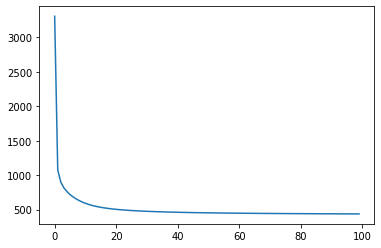

In [112]:
plt.plot(losses)

In [113]:
vectors = (model.weight.weight.to('cpu').detach() + model.weight_tilde.weight.to('cpu').detach()).numpy()

In [114]:
vectors.shape

(4337, 30)

In [115]:
data['kmers_vec'] = [vectorizer.vectorize(x) for x in preprocessed_seq]

In [116]:
data['kmers_vec']

4       [2415, 2128, 1188, 3952, 1703, 1398, 4142, 132...
5       [4143, 2317, 2731, 2668, 473, 2317, 560, 2566,...
6       [1322, 320, 1241, 3057, 2798, 2804, 1853, 534,...
7       [2773, 1605, 3450, 2454, 3590, 2042, 1217, 330...
8       [1347, 3333, 3873, 2063, 707, 4236, 2007, 3477...
                              ...                        
5625    [2013, 69, 3148, 2309, 2765, 283, 995, 4224, 5...
5626    [1937, 3425, 977, 958, 1776, 4091, 387, 62, 34...
5627    [2905, 3291, 1824, 142, 3161, 868, 1706, 2292,...
5629    [3273, 785, 4149, 293, 2037, 2959, 2172, 233, ...
5630    [836, 3789, 3811, 2213, 1019, 1824, 2211, 1792...
Name: kmers_vec, Length: 4870, dtype: object

In [117]:
data['kmers_enc'] = [np.sum(vectors[[y for y in x if y!=-1], :], axis=0) for x in data['kmers_vec']]

In [118]:
gloveUtrs = np.vstack(data['kmers_enc'])

In [119]:
gloveUtrs.shape

(4870, 30)

In [120]:
np.isfinite(gloveUtrs).all()

True

In [121]:
fDf = pd.read_csv('../processed_data/fluorescence_dataset.csv')
fDf.dropna(subset=['intensity'],inplace=True)
fDf.head()

,gene,systematicName,intensity
0,SSA1,YAL005C,11.906396
1,ERP2,YAL007C,0.299776
2,FUN14,YAL008W,0.455914
3,SPO7,YAL009W,0.027090
5,SWC3,YAL011W,0.031941


In [122]:
whole = data[['gene', 'kmers_enc']].merge(fDf[['gene','intensity']], on='gene', how='inner')
whole.head()

,gene,kmers_enc,intensity
0,SSA1,"[4.4385433, -9.650375, -1.2108251, -4.379579, ...",11.906396
1,ERP2,"[17.401703, -3.614935, 19.347794, 4.8516173, 9...",0.299776
2,FUN14,"[10.619053, -0.6274934, 2.0292964, 1.6550517, ...",0.455914
3,SPO7,"[4.843187, -10.771448, 3.3429961, 0.72585744, ...",0.027090
4,SWC3,"[10.463615, -1.1386614, 1.0494357, -5.3141866,...",0.031941


In [123]:
i = whole['intensity'].copy()
mask = i > 0 # negative intensities make no sense
y = np.log(i[mask])
x = np.vstack(whole['kmers_enc'])[mask]

x = x[y>-20,:]
y = y[y>-20]

<AxesSubplot:xlabel='intensity', ylabel='Count'>

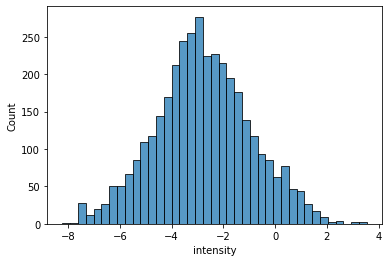

In [124]:
import seaborn as sns
sns.histplot(y)

In [125]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
pcs = PCA(2).fit_transform(StandardScaler().fit_transform(x))

In [126]:
from matplotlib import pyplot as plt

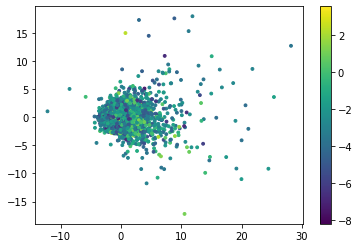

In [127]:
plt.scatter(pcs[:, 0], pcs[:, 1], c=y, s=8)
plt.colorbar()

No linear discriminant power found

In [128]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression().fit(x,y)
lm.score(x, y)

0.028254787082445554

In [129]:
from sklearn.ensemble import RandomForestRegressor

In [130]:
preds = RandomForestRegressor(n_estimators=500, n_jobs=-1).fit(x,y).predict(x)

In [131]:
np.sum((preds - y)**2)

1646.6200907778584

In [132]:
np.sum((y)**2)

40446.448386481046

In [133]:
from sklearn.metrics.pairwise import cosine_similarity
xcos = cosine_similarity(x, x)

In [134]:
xcos.shape

(3640, 3640)

In [135]:
xcos.max()

1.0000004

In [136]:
xcos.min(), xcos.max()

(-0.8649777, 1.0000004)

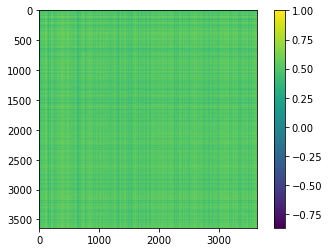

In [137]:
plt.imshow(xcos)
plt.colorbar()

In [138]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
pcs = PCA(300).fit_transform(RobustScaler().fit_transform(xcos))

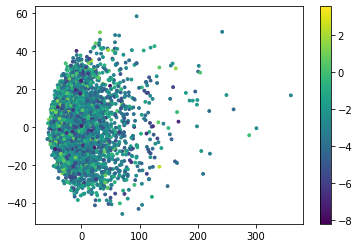

In [139]:
plt.scatter(pcs[:, 0], pcs[:, 1], c=y, s=8)
plt.colorbar()

In [140]:
cos_preds = RandomForestRegressor(n_estimators=500, n_jobs=-1).fit(pcs,y).predict(pcs)

In [141]:
np.sum((cos_preds - y)**2)

1669.211461810944

In [142]:
from sklearn import tree
treeRegressor = tree.DecisionTreeRegressor(max_leaf_nodes=200, criterion='friedman_mse')
tree_preds = treeRegressor.fit(x, y).predict(x)
np.sum((tree_preds - y)**2)

6594.373689764442

In [143]:
from sklearn import tree
treeRegressor = tree.DecisionTreeRegressor(max_leaf_nodes=200, criterion='friedman_mse')
tree_preds = treeRegressor.fit(pcs, y).predict(pcs)
# import graphviz 
# dot_data = tree.export_graphviz(treeRegressor, filled=True, out_file=None) 
# graph = graphviz.Source(dot_data)
# graph.render("gloveUtrsTree") 
print(np.sum((tree_preds - y)**2))


5643.510815713231


In [144]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, np.exp(y), train_size=0.8, random_state=42)
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=50, max_depth=10, oob_score=True, random_state=0, n_jobs=-1)
rf.fit(X_train, y_train)
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, pearsonr
predicted_train = rf.predict(X_train)
predicted_test = np.log(rf.predict(X_test))
test_score = r2_score(np.log(y_test), predicted_test)
spearman = spearmanr(np.log(y_test), predicted_test)
pearson = pearsonr(np.log(y_test), predicted_test)
print(f'Out-of-bag R-2 score estimate: {rf.oob_score_:>5.3}')
print(f'Test data R-2 score: {test_score:>5.3}')
print(f'Test data Spearman correlation: {spearman[0]:.3}')
print(f'Test data Pearson correlation: {pearson[0]:.3}')


Out-of-bag R-2 score estimate: -0.168
Test data R-2 score: -0.825
Test data Spearman correlation: 0.084
Test data Pearson correlation: 0.0886


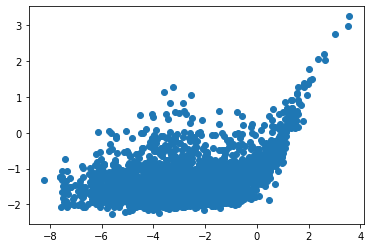

In [145]:
plt.scatter(np.log(y_train), np.log(predicted_train))

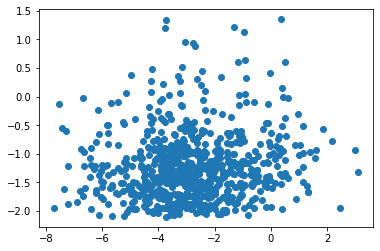

In [146]:
plt.scatter(np.log(y_test), predicted_test)

In [147]:
import pickle
with open('../processed_data/utrs_glove_embeddings.pkl', 'wb') as out:
    pickle.dump({'data':np.vstack(data['kmers_enc']),'genes':data['gene']}, out)

In [148]:
!git add ../*

In [149]:
!git commit -m 'Testing on GLoVe and DF-IDF'

[nlp3utr 899f5f1] Testing on GLoVe and DF-IDF
 11 files changed, 19697 insertions(+), 644 deletions(-)
 create mode 100644 code/Train TFIDF on UTRS.ipynb
 create mode 100644 code/gloveUtrsTree
 create mode 100644 code/gloveUtrsTree.pdf
 create mode 100644 code/iris
 rewrite model/utrs/gloveModel (85%)
 create mode 100644 model/utrs/gloveModel_specific
 create mode 100644 processed_data/utrs/cooccurence_spec/cooccurrence.hdf5
 create mode 100644 processed_data/utrs/cooccurence_spec/vocab.pkl
 rewrite processed_data/utrs_glove_embeddings.pkl (82%)


In [150]:
!git push origin

Enumerating objects: 28, done.
Counting objects: 100% (28/28), done.
Delta compression using up to 16 threads
Compressing objects: 100% (17/17), done.
Writing objects: 100% (19/19), 32.67 MiB | 363.00 KiB/s, done.
Total 19 (delta 5), reused 0 (delta 0)
remote: Resolving deltas: 100% (5/5), completed with 5 local objects.
remote: warning: See http://git.io/iEPt8g for more information.
remote: warning: File processed_data/utrs/cooccurence_spec/cooccurrence.hdf5 is 80.11 MB; this is larger than GitHub's recommended maximum file size of 50.00 MB
remote: warning: GH001: Large files detected. You may want to try Git Large File Storage - https://git-lfs.github.com.
To github.com:IBP-21-22/intbioproj.git
   baa2e7a..899f5f1  nlp3utr -> nlp3utr
